In [1]:
import re
import sys
import warnings
import matplotlib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-07-01"

In [3]:
df_final = pd.read_excel("{}/{}/df_hurst_tts_{}.xlsx".format(output_path, re.sub("-", "", input_generation_date), re.sub("-", "", input_generation_date)))
df_final

,time_series,n_simulation,hurst_exponent,hurst_exponent_sd,tts_exponent,tts_sd,real_hurst_exponent_sd,real_tts_exponent_sd
0,absolute log-return,200,0.40,0.02,0.217623,0.008948,0.001414,0.000633
1,absolute log-return,30,0.46,0.02,0.218866,0.009081,0.001414,0.000642
2,absolute log-return,200,0.50,0.02,0.220284,0.010694,0.001414,0.000756
3,absolute log-return,30,0.52,0.02,0.218787,0.008455,0.001414,0.000598
4,absolute log-return,30,0.58,0.02,0.217247,0.007686,0.001414,0.000543
5,absolute log-return,30,0.64,0.02,0.217949,0.010746,0.001414,0.000760
6,absolute log-return,200,0.70,0.02,0.220507,0.010561,0.001414,0.000747
7,absolute log-return,30,0.76,0.02,0.221775,0.008960,0.001414,0.000634
8,absolute log-return,30,0.82,0.02,0.224448,0.024808,0.001414,0.001754
9,absolute log-return,30,0.88,0.02,0.221317,0.025788,0.001414,0.001823


In [4]:
# Estimation of p-norm ----
def estimate_p_norm(x, y, p):
    if p == 0:
        z = np.exp(0.5 * np.mean(np.log(np.power(np.abs(x-y), 2))))
    else:
        z = np.power(np.abs(x - y), 1 / p)
    return np.mean(z)

# Estimation of coefficient of determination R2 ----
def estimate_coefficient_of_determination(y, y_fitted):
    return 1 - np.sum(np.power(y - y_fitted, 2)) / np.sum(np.power(y - np.mean(y), 2))

# Plot evolution of Hurst, Temporal Fluctuation Scaling (TFS) and Temporal Theil Scaling (TTS) parameters ----
def plot_hurst_tts(
    df_graph,
    degree_tts,
    width,
    height,
    threshold_tts=0,
    markersize=2,
    fontsize_labels=13.5,
    fontsize_legend=11.5,
    usetex=False,
    n_cols=4,
    n_x_breaks=10,
    n_y_breaks=10,
    fancy_legend=True,
    dpi=150,
    save_figures=True,
    output_path="../output_files",
    information_name="",
    input_generation_date="2023-07-01"
):
    # Begin plot inputs ----
    matplotlib.rcParams.update(
        {
            "font.family": "serif",
            "text.usetex": usetex,
            "pgf.rcfonts": False
        }
    )
    
    fig1, ax1 = plt.subplots(1, 2) # TTS vs Hurst exponent
    fig1.set_size_inches(w = width, h = height)
    
    df_hurst_tts = pd.DataFrame()    
    counter_i = 0
    for j in sorted(df_graph["time_series"].unique().tolist()):
        # Filter information ----
        df_aux = df_graph[df_graph["time_series"] == j]

        # Extract empirical data (All dates, exponents information and others) ----
        tts_exponent = df_aux["tts_exponent"]
        hurst_exponent = df_aux["hurst_exponent"]
        tts_exponent_sd = df_aux["real_tts_exponent_sd"]
        hurst_exponent_sd = df_aux["real_hurst_exponent_sd"]
        
        # Estimation of parameters with theorical value and uncertainty ----
        try:
            popt_tts, pcov_tts = np.polyfit(
                x = hurst_exponent.to_numpy(),
                y = tts_exponent.to_numpy(),
                deg = degree_tts,
                cov = True
            )
        except Exception as e:
            popt_tts, pcov_tts = np.zeros(degree_tts + 1), np.zeros([degree_tts + 1, degree_tts + 1])
            
        error_tts = np.sqrt(np.diag(pcov_tts)) #/ np.sqrt(len(tts_exponent))
        error_tts[np.isinf(error_tts)] = 0
        lower_tts = popt_tts - error_tts 
        upper_tts = popt_tts + error_tts
        
        estimated_tts_mean_ = np.poly1d(popt_tts)(hurst_exponent)                    
        estimated_tts_lower = np.poly1d(lower_tts)(hurst_exponent)                 
        estimated_tts_upper = np.poly1d(upper_tts)(hurst_exponent)

        # Estimation of average error with residuals (TFS) ----
        r2_tts = estimate_coefficient_of_determination(y = tts_exponent.values, y_fitted = estimated_tts_mean_)
        ae_tts = estimate_p_norm(x = tts_exponent.values, y = estimated_tts_mean_, p = 1)        
        
        # Final data of regression ----        
        df_hurst_tts = df_hurst_tts.append(
            pd.DataFrame(
                {
                    "symbol" : ["Fractional Brownian Motion"] * (degree_tts + 1),
                    "time_series" : [j] * (degree_tts + 1),
                    "parameters" : popt_tts,
                    "error_parameters" : error_tts,
                    "rsquared" : [r2_tts] * (degree_tts + 1),
                    "average_error" : [ae_tts] * (degree_tts + 1)
                }
            )
        )
        
        # Plot graph (about Hurst exponent and TTS exponent) ----
        plot_1 = ax1[counter_i]
        
        ax1[counter_i].errorbar(
            x = hurst_exponent,
            y = tts_exponent,
            xerr = hurst_exponent_sd,
            yerr = tts_exponent_sd,
            alpha = 1,
            zorder = 2,
            color = "red",
            marker = "o",
            ecolor = "black",
            elinewidth = 2,
            capsize = markersize + 3,
            linestyle = "",
            uplims = False, 
            lolims = False,
            xuplims = False, 
            xlolims = False,
            label = "Estimated simulation data",
            markersize = markersize + 3,
            capthick = 1
        )
        
        if np.unique(estimated_tts_mean_)[0] != 0:
            ax1[counter_i].plot(
                hurst_exponent,
                estimated_tts_mean_,
                alpha = 1,
                zorder = 2,
                color = colors[counter_i],
                linewidth = 3,
                label = "Theoretical fit"
            )
            ax1[counter_i].fill_between(
                hurst_exponent,
                estimated_tts_lower,
                estimated_tts_upper,
                where = (
                    (estimated_tts_upper >= estimated_tts_lower) &
                    (estimated_tts_upper >= estimated_tts_mean_) &
                    (estimated_tts_mean_ >= estimated_tts_lower)
                ),
                alpha = 0.19,
                facecolor = colors[counter_i],
                interpolate = True
            )
        
        ax1[counter_i].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 12)
        ax1[counter_i].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 6)
        ax1[counter_i].xaxis.set_major_locator(mtick.MaxNLocator(n_x_breaks))
        ax1[counter_i].xaxis.set_minor_locator(mtick.MaxNLocator(5 * n_x_breaks))
        ax1[counter_i].yaxis.set_major_locator(mtick.MaxNLocator(n_y_breaks))
        ax1[counter_i].yaxis.set_minor_locator(mtick.MaxNLocator(5 * n_y_breaks))
        ax1[counter_i].xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
        ax1[counter_i].yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
        ax1[counter_i].tick_params(axis = "x", labelrotation = 90)
        ax1[counter_i].set_xlabel("Hurst exponent - {}".format(j.capitalize()), fontsize = fontsize_labels)
        ax1[counter_i].set_ylabel("TTS exponent - {}".format(j.capitalize()), fontsize = fontsize_labels)
        ax1[counter_i].legend(fancybox = fancy_legend, shadow = True, ncol = n_cols, fontsize = fontsize_legend)
        ax1[counter_i].set_title(
            r"({}) $MAE_p={}$, $N_{{fBm}}={}$, $r_{{fBm}}={}$, $R^2={}\%$".format(
                chr(counter_i + 65),
                max([round(ae_tts.min(), 5), 0]),
                df_aux["n_simulation"].max(),
                threshold_tts,
                max([round(r2_tts * 100, 2), 0])
            ),
            loc = "left",
            y = 1.005,
            fontsize = fontsize_labels
        )
    
        # Function development ----
        counter_i += 1
        print("Generated plot for fBm and time series {}".format(j))
    
    # Final output and plotting
    fig1.tight_layout()
    if save_figures:
        # Plot graph (Temporal Fluctuation Scaling) ----
        plt.show()
        fig1.savefig(
            "{}/{}_hurst_tts_relation_{}.png".format(output_path, information_name, re.sub("-", "", input_generation_date)),
            bbox_inches = "tight",
            facecolor = fig1.get_facecolor(),
            transparent = False,
            pad_inches = 0.03,
            dpi = dpi
        )
        
    plt.close()
    return df_hurst_tts

Generated plot for fBm and time series absolute log-return
Generated plot for fBm and time series log-return volatility


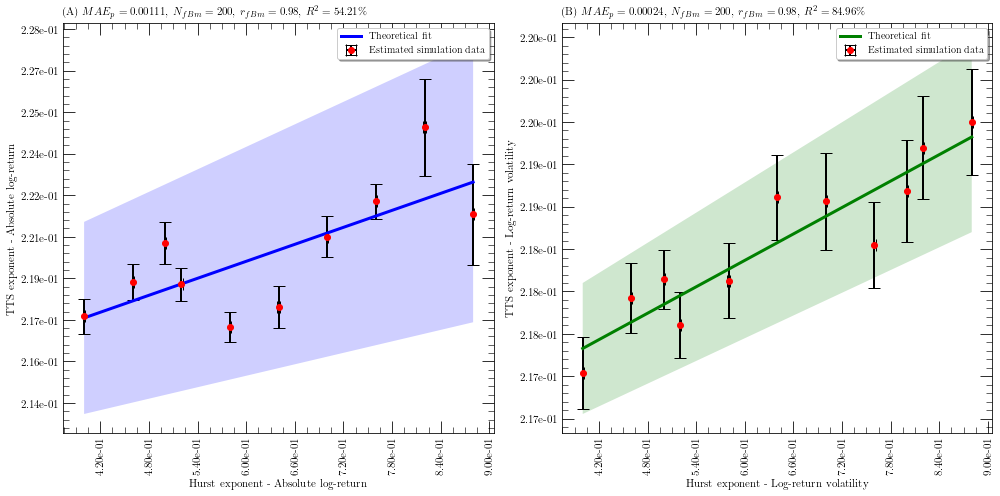

,symbol,time_series,parameters,error_parameters,rsquared,average_error
0,Fractional Brownian Motion,absolute log-return,0.010225,0.003322,0.542133,0.001107
1,Fractional Brownian Motion,absolute log-return,0.213479,0.002141,0.542133,0.001107
0,Fractional Brownian Motion,log-return volatility,0.004158,0.000583,0.849627,0.000241
1,Fractional Brownian Motion,log-return volatility,0.215799,0.000385,0.849627,0.000241


In [5]:
df_plot = plot_hurst_tts(
    df_graph = df_final,
    degree_tts = 1,
    width = 14,
    height = 7,
    threshold_tts = 0.98,
    markersize = 3,
    fontsize_labels = 11,
    fontsize_legend = 10,
    usetex = True,
    n_cols = 1,
    n_x_breaks = 10,
    n_y_breaks = 10,
    fancy_legend = True,
    dpi = 200,
    save_figures = True,
    output_path = "{}/{}".format(output_path, re.sub("-", "", input_generation_date)),
    information_name = "fBm",
    input_generation_date = input_generation_date
)

df_plot